<h2 style='color:#50E15F'>Teste técnico - Risk Analyst Cloudwalk.</h2>
<h2>
Candidate: Vinícius S. Brandão
</h2>


To solve the technical part of this challenge, the chosen tool was Python. This Python notebook has a structured approach to solve the problems, as follows:

<ul>
<li>
Intent: Clearly state what is desired or possible.</li>
<li>
Code: Implement to extract desired information or results. With commented steps.
</li>
<li>
Output & Analysis: Interpret and analyze the results in relation to the intended outcomes.
</li>
</ul>


<h1 style='color:#ED7261'>RAW DATA ANALYSIS</h1>

<h3>First step</h3>
Before the implementation to our solution, it is important to import all the tools used to solve the problem. 

In this kind of problem, it is important that before we start developing any kind of solution, that we have a good understanding of what kind of information the dataset contains, if it is complete. This allows us to better develop a fitting solution that will be reliable and practical.

In [155]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import StandardScaler

After importing the necessary libraries, it is crucial to import and sanitize the data, extracting the maximum amount of useful information from the dataset.

Before proceeding with the solutions to tasks 3.2.1 and 3.3, I will address task 3.2.2:

    Location data holds significant value in fraud detection, as it can be cross-referenced with historical location data to identify suspicious activities. (The following suggestion is based on the data analysis done below). Establishing a comprehensive historical context for each user, particularly when users are identified by card or device ID, is also useful. Without sufficient transactional context attributed to each user, there may be limitations in gathering transactional data, hindering our ability to establish a comparative framework for identifying normal transactions associated with each card.

The first thing to be done is trying to pull out useful data from the dataset before procceding to model creation or other solution implementation.

In the two following cells, the data is pulled from the csv archive, data integrity is verified and adressed, the transaction time is transformed to a usable shape (converted from string/timestap to integer) and a new column is added with the hours regardless of date.

In [156]:
dataset = pd.read_csv('transactions.csv')

def clean_card_number(card):
    return int(''.join(filter(str.isdigit, card)))
dataset['card_number'] = dataset['card_number'].apply(clean_card_number)

# Convert 'transaction_date' to datetime
dataset['transaction_date'] = pd.to_datetime(dataset['transaction_date'])

# Extract hour and minute components separately
# And Combine hour and minute components into a single integer
dataset['transaction_hour'] = dataset['transaction_date'].dt.hour.astype(int)
dataset['transaction_minute'] = dataset['transaction_date'].dt.minute.astype(int)
dataset['transaction_hour_minute'] = dataset['transaction_hour'] * 100 + dataset['transaction_minute']

# Drop the separate hour and minute columns for irrelevancy
dataset.drop(columns=['transaction_hour', 'transaction_minute'], inplace=True)



dataset['transaction_date'] = dataset['transaction_date'].astype(int)

print(dataset.head(1))



   transaction_id  merchant_id  user_id  card_number     transaction_date  \
0        21320398        29744    97051   4345059116  1575242192812632000   

   transaction_amount  device_id  has_cbk  transaction_hour_minute  
0              374.56   285475.0    False                     2316  


In [157]:
print('Transações legítimas (FALSE) vs Fraudes (TRUE):')
print(dataset['has_cbk'].value_counts())

print()
print('Integridade de dados:')
missing_values = dataset.isnull().sum()
print(missing_values)

# Changes the missing device ids to 0
dataset['device_id'] = dataset['device_id'].fillna(0)


Transações legítimas (FALSE) vs Fraudes (TRUE):
False    2808
True      391
Name: has_cbk, dtype: int64

Integridade de dados:
transaction_id               0
merchant_id                  0
user_id                      0
card_number                  0
transaction_date             0
transaction_amount           0
device_id                  830
has_cbk                      0
transaction_hour_minute      0
dtype: int64


There are a total of 3199 transactions, with 391 (12%) identified as fraudulent and 2808 (88%) categorized as legitimate transactions.

Additionally, there are 830 transactions where the device ID is missing. These entries cannot be disregarded as they represent genuine usage data. To address this issue, a workaround was implemented: missing device IDs will be replaced with the device ID "0".

Upon manual inspection of the dataset, it was discovered that 67 out of the 830 transactions lacking device IDs (8%) were fraudulent. This suggests that the absence of device IDs does not appear to have a significant impact on the occurrence of fraud upon initial examination.

<h3>Second Step</h3>
In the next step, we aim to further investigate the patterns in our dataset, using any analythical tools that could provide valuable insight for our application.

First a confusion matrix will be enployed to allow us to estimate what are the most important features to be analyzed. This will be started by grouping transactions with common traits and analyzing how the traits relate to each other.

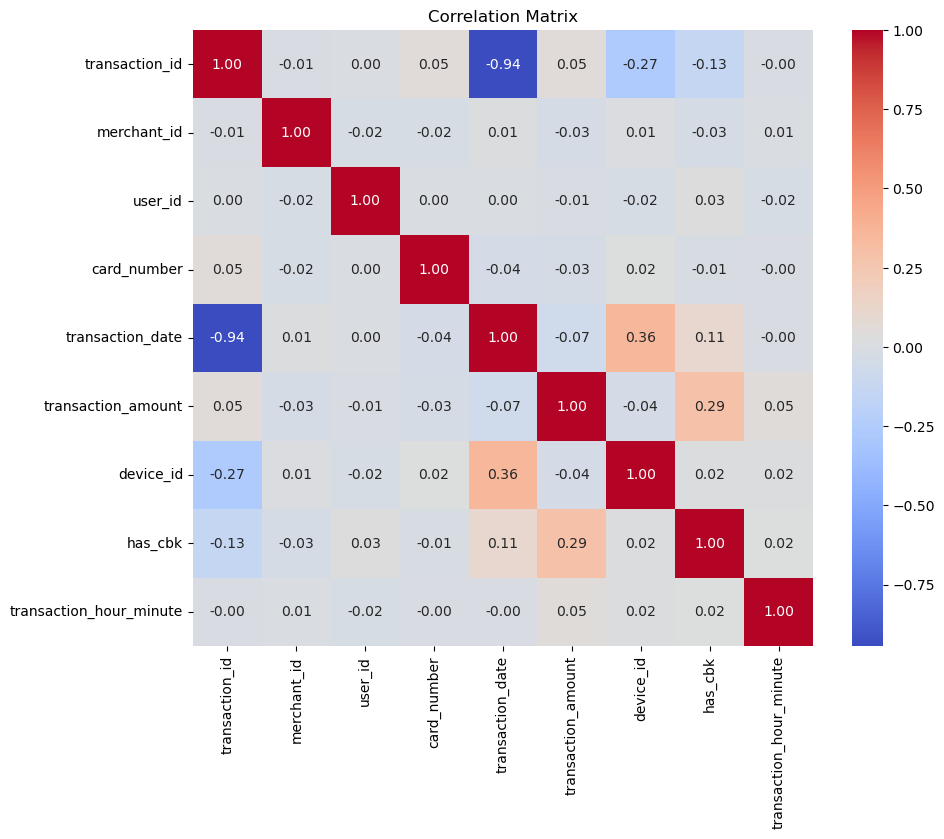

In [158]:
corr_matrix = dataset.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

From the correlation analysis, it is evident that <span style='color:orange'>most of the characteristics exhibit a weak correlation with the variable indicating fraudulent transactions</span>, labeled as "has_cbk". 

The characteristics with stronger correlation are transaction id (that will not be analyzed, because it is unique to each transaction), transaction amount and transaction date that will be analyzed in the form of transaction_hour_minute, user id will also be analysed as a counterpart to card_id to determine if there are users utilizing multiple cards. Although merchant ID could potentially yield valuable recurrent data, it will not be explored for this project.

Now that we have seen the correlation, the next cells and graphs will explore the groups.
<ul>
<li>
The first grouping will be based on device ID.
</li>
<li>
The second grouping will be by card number.
</li>
<li>
The third grouping will be by transaction amount.
</li>
<li>
Lastly, we'll explore groups based on transaction time.
</li>
</ul>

Number of registered devices:
1997



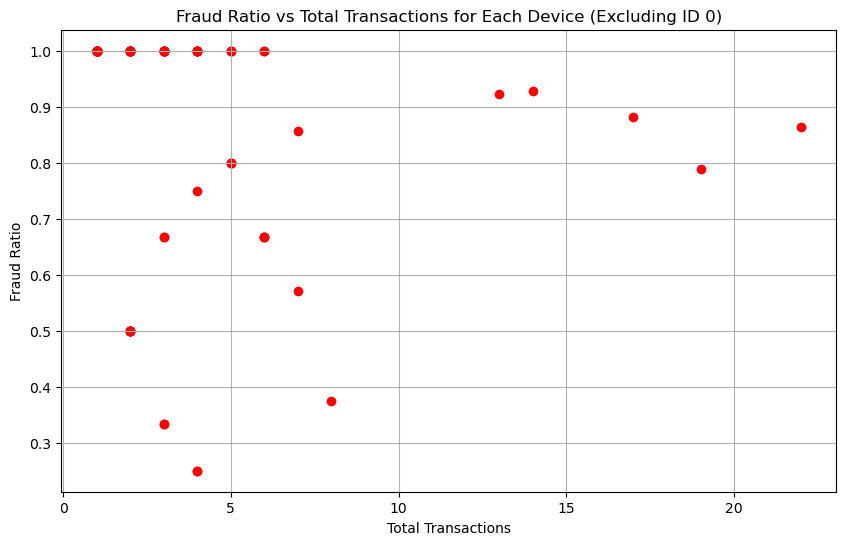

In [159]:

grouped_devices = dataset.groupby('device_id').size()
print('Number of registered devices:')
print(grouped_devices.__len__())
print()

# Calculate the total registered transactions for each card
total_transactions_by_device = grouped_devices

# Find where a fraud occured and count occurrences
fraud_occurrences = dataset[dataset['has_cbk'] == True]
count = fraud_occurrences.shape[0]

# Calculate the count of fraud occurrences for each card
fraud_occurrences_by_device = fraud_occurrences.groupby('device_id').size()

# Compare fraud occurrences to registered transactions for each card
fraud_ratio_by_device = fraud_occurrences_by_device / total_transactions_by_device


# There are 830 devices with ID 0, so they were removed not to skew the graph. 
filtered_total_transactions = total_transactions_by_device[total_transactions_by_device.index != 0]
filtered_fraud_ratio = fraud_ratio_by_device[total_transactions_by_device.index != 0]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(filtered_total_transactions, filtered_fraud_ratio, color='r')
plt.xlabel('Total Transactions')
plt.ylabel('Fraud Ratio')
plt.title('Fraud Ratio vs Total Transactions for Each Device (Excluding ID 0)')

plt.grid(True)
plt.show()



Upon analyzing the number of transactions by device ID and their corresponding fraud ratios, it becomes evident that when a device has <span style='color:orange'>more than 10 transactions</span>, the likelihood of fraud is significantly high, approaching <span style='color:orange'>nearly 100%</span> in all cases observed. However, when a device has fewer than 10 transactions registered, it is difficult to draw definitive conclusions beyond acknowledging the presence of frauds within this subset.

In [182]:
grouped_transactions = dataset.groupby('card_number').size()
print('registered transactions:')
print(grouped_transactions)
print()


# Print the ammount of occurences of fraud
print("Occurrences of 'fraud':")
# print(occurrences)
print("Count of occurrences:", count)

# print the ammount of frauds of each card
grouped_frauds = fraud_occurrences.groupby('card_number').size()
print(grouped_frauds)



registered transactions:
card_number
45938330       1
50677590       1
230744950      1
404024820      1
406655470      1
              ..
6550066876     1
6550077278     1
23074410000    1
44152410003    1
45321110004    1
Length: 2925, dtype: int64

Occurrences of 'fraud':
Count of occurrences: 391
card_number
230744950     1
515590820     1
606282450     1
2306505729    1
2307444802    2
             ..
6504864290    1
6505167004    1
6505169201    3
6507275418    3
6516532256    5
Length: 274, dtype: int64


In [161]:
# Calculate the total registered transactions for each card
total_transactions_by_card = grouped_transactions

# Calculate the count of fraud occurrences for each card
fraud_occurrences_by_card = fraud_occurrences.groupby('card_number').size()

# Compare fraud occurrences to registered transactions for each card
fraud_ratio_by_card = fraud_occurrences_by_card / total_transactions_by_card

fraud_ratio_by_card = fraud_ratio_by_card.fillna(0)

# Print the fraud ratio for each card
print("Fraud ratio for each card:")
print(fraud_ratio_by_card)


Fraud ratio for each card:
card_number
45938330       0.0
50677590       0.0
230744950      1.0
404024820      0.0
406655470      0.0
              ... 
6550066876     0.0
6550077278     0.0
23074410000    0.0
44152410003    0.0
45321110004    0.0
Length: 2925, dtype: float64


In the last two cells, we can see that there are <span style='color:orange'>2925 cards</span> on the database and <span style='color:orange'>274 of those have registered fraudulent transactions</span>. So there is no significant individual card history to be analyzed to track spending habits and do an individual card fraud analysis.

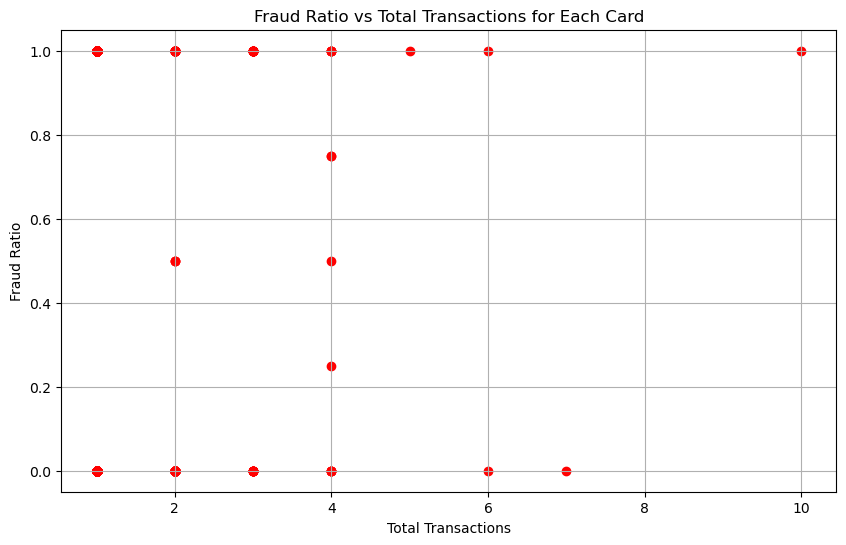

In [162]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(total_transactions_by_card, fraud_ratio_by_card, color='r')
plt.xlabel('Total Transactions')
plt.ylabel('Fraud Ratio')
plt.title('Fraud Ratio vs Total Transactions for Each Card')



plt.grid(True)
plt.show()



This graph shows us that the number of registered transactions is <span style='color:chocolate'>not particularly telling of fraud</span>. But, it is noteworthy that as the device id data showed us, if more than 10 transactions are linked to the same entity, this migh be a strong sign of fraud. So it is necessary to find other methods that might help us find a pattern.

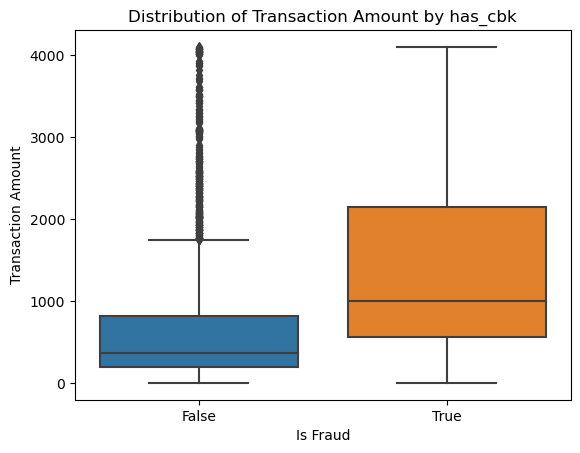

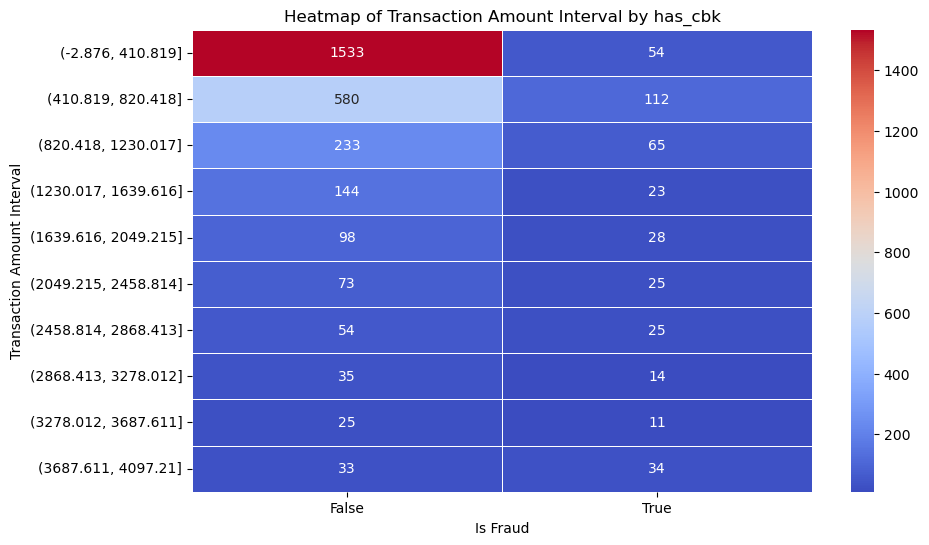

In [179]:

sns.boxplot(x='has_cbk', y='transaction_amount', data=dataset)
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.title('Distribution of Transaction Amount by has_cbk')
plt.show()

num_intervals = 10
dataset['transaction_amount_interval'] = pd.cut(dataset['transaction_amount'], bins=num_intervals)

plt.figure(figsize=(10, 6))
heatmap_data = dataset.pivot_table(index='transaction_amount_interval', columns='has_cbk', aggfunc='size', fill_value=0)
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='d', linewidths=.5)
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount Interval')
plt.title('Heatmap of Transaction Amount Interval by has_cbk')
plt.show()


The box plot and heatmap suggest that the transaction amount is typically higher in fraudulent interactions, but there are many outliers that also indicate big amount transactions can be legitimate. So, one viable solution to reduce the amount of fraud would be to raise suspicion of fraud on large amount transactions.

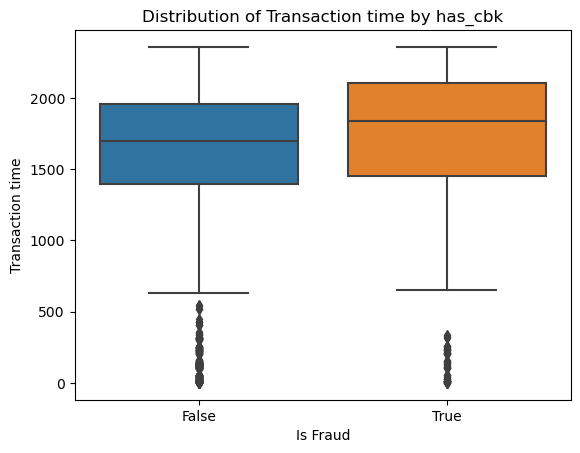

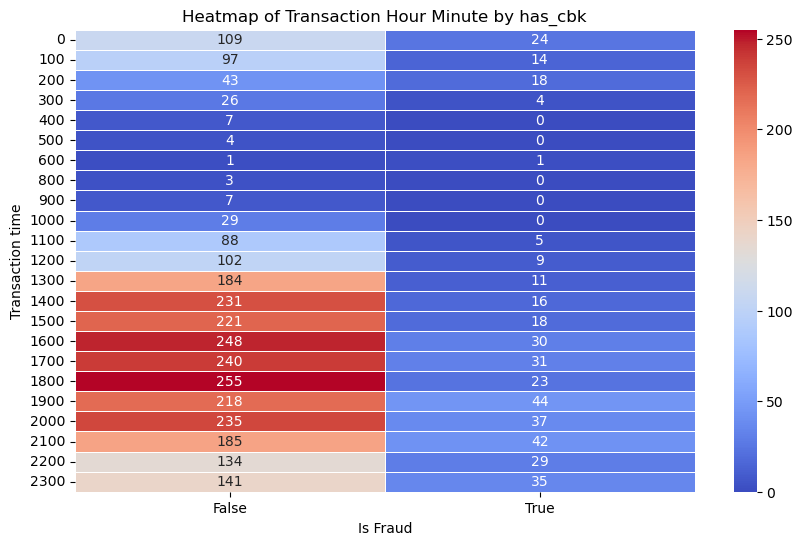

In [173]:

sns.boxplot(x='has_cbk', y='transaction_hour_minute', data=dataset)
plt.xlabel('Is Fraud')
plt.ylabel('Transaction time')
plt.title('Distribution of Transaction time by has_cbk')
plt.show()

dataset['transaction_hour_minute_rounded'] = dataset['transaction_hour_minute'] // 100 * 100

# Create the heatmap
plt.figure(figsize=(10, 6))
heatmap_data = dataset.pivot_table(index='transaction_hour_minute_rounded', columns='has_cbk', aggfunc='size', fill_value=0)
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='d', linewidths=.5)
plt.xlabel('Is Fraud')
plt.ylabel('Transaction time')
plt.title('Heatmap of Transaction Hour Minute by has_cbk')
plt.show()

In [183]:
# Round transaction_hour_minute to the nearest 100
dataset['transaction_hour_minute_rounded'] = dataset['transaction_hour_minute'] // 100 * 100

# Calculate the ratio of False to True for each interval
ratio_data = dataset.groupby(['transaction_hour_minute_rounded', 'has_cbk']).size().unstack(fill_value=0)
ratio_data['ratio'] =   ratio_data[True]/ (ratio_data[False] +  ratio_data[True])

# print(ratio_data['ratio'])
sorted_ratio_data = ratio_data.sort_values(by='ratio', ascending=False)
print(sorted_ratio_data['ratio'])

# Identify consecutive intervals with ratios above the threshold
threshold = 0.10
higher_ratio_clusters = []
current_cluster = []

for index, row in sorted_ratio_data.iterrows():
    if row['ratio'] > threshold:
        current_cluster.append(index)
    else:
        if current_cluster:
            higher_ratio_clusters.append(current_cluster)
            current_cluster = []

# Print the identified higher ratio clusters
print("Higher Ratio :")
for cluster in higher_ratio_clusters:
    print(cluster)


transaction_hour_minute_rounded
600     0.500000
200     0.295082
2300    0.198864
2100    0.185022
0       0.180451
2200    0.177914
1900    0.167939
2000    0.136029
300     0.133333
100     0.126126
1700    0.114391
1600    0.107914
1800    0.082734
1200    0.081081
1500    0.075314
1400    0.064777
1300    0.056410
1100    0.053763
400     0.000000
1000    0.000000
900     0.000000
800     0.000000
500     0.000000
Name: ratio, dtype: float64
Higher Ratio :
[600, 200, 2300, 2100, 0, 2200, 1900, 2000, 300, 100, 1700, 1600]


In the last 3 cells, we extract more data on what time fraud is more common and the when there is a higher ratio of fraud. The graphs show us that the most transactions occur between 11am and 1am (on the next day), and the fraudulent amount is larger than 10% between 4pm and 1am, but it is important to notice that 6am has 50% of fraud ratio. 

This is Very useful, since we can use this information to better estimate the likelyhood of fraud when joined with transaction ammounts. 

<h1 style='color:#ED7261'>DETECTION MODELS</h1>

This problem can be approached from a multitude of ways. It is possible to establish arbitrary criteria to enforce some kind of user verification by a second factor to authorize the transaction, an automatic statistical machine to autodetect fraud. 

But to do this, it is important to first state the fact that it is impossible to have a 100% accurate method, the goal is to minimize as best we can the amount of fraud without impeading legitimate transactions. Knowing that false positives and negatives for  are inevitable, we have to optimize to prioritize one over the other. For this project, false positives will be prioritized, because in this case, false positives would bring more safety to the user and the credit card company at the expanse of inconvenience for the end users.

In [167]:
X = dataset.drop('has_cbk', axis=1)
y = dataset['has_cbk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print(y_test.value_counts())


False    550
True      90
Name: has_cbk, dtype: int64


The chosen method was a neural network, it brought interesting results and a good overall generalization. The hyperparameters and activation functions were tuned, regularization and normalization were applied and the network topology was optimized, to bring a good result. 

In this case, an artificial neural network would have to be more advanced than the time I have allows me to develop to this problem. So other simpler solutions will be tried to increase both prediction capabilities and speed performance.

Accuracy: 88%
Confusion Matrix:
[[531  19]
 [ 59  31]]


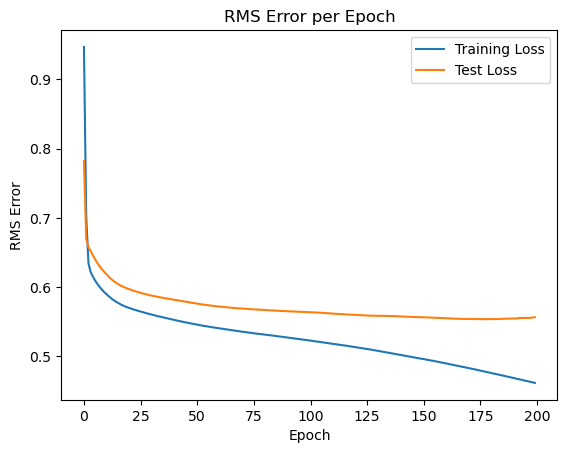

In [168]:
# 200 epch rstate=46

# Define the model
model = MLPClassifier(hidden_layer_sizes=(64, 32, 16, 8), batch_size=50, activation='relu', solver='sgd',
                      max_iter=200, alpha=0.01, learning_rate='adaptive', random_state=46)

# Initialize lists to store training and test losses per epoch
train_loss = []
test_loss = []

# Train the model and collect loss per epoch
for epoch in range(200):
    model.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))
    train_loss.append(model.loss_)
    
    # Calculate test loss
    y_pred_proba = model.predict_proba(X_test_scaled)
    loss = log_loss(y_test, y_pred_proba)
    test_loss.append(loss)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = model.score(X_test_scaled, y_test)
print(f"Accuracy: {100*accuracy:.0f}%")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting RMS error per epoch
plt.plot(np.sqrt(train_loss), label='Training Loss')
plt.plot(np.sqrt(test_loss), label='Test Loss')
plt.title('RMS Error per Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMS Error')
plt.legend()
plt.show()


Accuracy: 87%
Confusion Matrix:
[[531  19]
 [ 63  27]]


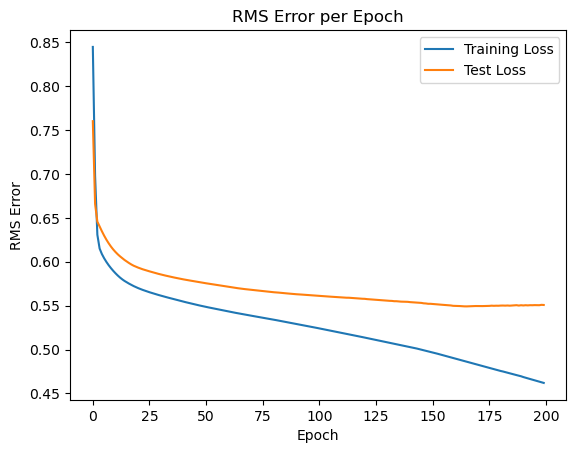

In [169]:
# 200 epch rstate=42

# Define the model
model = MLPClassifier(hidden_layer_sizes=(64, 32, 16, 8), batch_size=50, activation='relu', solver='sgd',
                      max_iter=200, alpha=0.01, learning_rate='adaptive', random_state=42)

# Initialize lists to store training and test losses per epoch
train_loss = []
test_loss = []

# Train the model and collect loss per epoch
for epoch in range(200):
    model.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))
    train_loss.append(model.loss_)
    
    # Calculate test loss
    y_pred_proba = model.predict_proba(X_test_scaled)
    loss = log_loss(y_test, y_pred_proba)
    test_loss.append(loss)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = model.score(X_test_scaled, y_test)
print(f"Accuracy: {100*accuracy:.0f}%")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting RMS error per epoch
plt.plot(np.sqrt(train_loss), label='Training Loss')
plt.plot(np.sqrt(test_loss), label='Test Loss')
plt.title('RMS Error per Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMS Error')
plt.legend()
plt.show()



Accuracy: 87%
Confusion Matrix:
[[510  40]
 [ 44  46]]


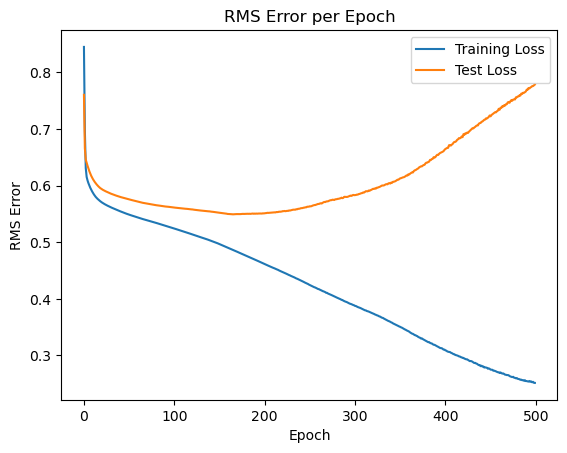

In [170]:
# 500 epch rstate=42

# Define the model
model = MLPClassifier(hidden_layer_sizes=(64, 32, 16, 8), batch_size=50, activation='relu', solver='sgd',
                      max_iter=500, alpha=0.01, learning_rate='adaptive', random_state=42)

# Initialize lists to store training and test losses per epoch
train_loss = []
test_loss = []

# Train the model and collect loss per epoch
for epoch in range(500):
    model.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))
    train_loss.append(model.loss_)
    
    # Calculate test loss
    y_pred_proba = model.predict_proba(X_test_scaled)
    loss = log_loss(y_test, y_pred_proba)
    test_loss.append(loss)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = model.score(X_test_scaled, y_test)
print(f"Accuracy: {100*accuracy:.0f}%")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting RMS error per epoch
plt.plot(np.sqrt(train_loss), label='Training Loss')
plt.plot(np.sqrt(test_loss), label='Test Loss')
plt.title('RMS Error per Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMS Error')
plt.legend()
plt.show()



Accuracy: 85%
Confusion Matrix:
[[488  62]
 [ 37  53]]


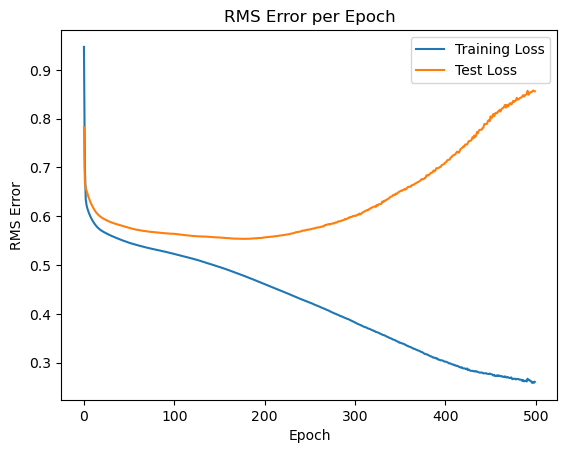

In [171]:
# 500 epch rstate=46

# Define the model
model = MLPClassifier(hidden_layer_sizes=(64, 32, 16, 8), batch_size=50, activation='relu', solver='sgd',
                      max_iter=500, alpha=0.01, learning_rate='adaptive', random_state=46)

# Initialize lists to store training and test losses per epoch
train_loss = []
test_loss = []

# Train the model and collect loss per epoch
for epoch in range(500):
    model.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))
    train_loss.append(model.loss_)
    
    # Calculate test loss
    y_pred_proba = model.predict_proba(X_test_scaled)
    loss = log_loss(y_test, y_pred_proba)
    test_loss.append(loss)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = model.score(X_test_scaled, y_test)
print(f"Accuracy: {100*accuracy:.0f}%")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


# Plotting RMS error per epoch
plt.plot(np.sqrt(train_loss), label='Training Loss')
plt.plot(np.sqrt(test_loss), label='Test Loss')
plt.title('RMS Error per Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMS Error')
plt.legend()
plt.show()



Four models were trained to compare the effects of tuning on model performance, particularly examining the phenomenon of overfitting. The parameters were kept consistent across all models.

The models trained with <span style='color:#ED7261'>200 epoch</span> show the better accuracy and loss for the classification in general, when compared to the other modelsHowever, these models struggled to accurately identify potentially fraudulent transactions, misclassifying over 65% of fraud cases as legitimate transactions. Consequently these models would fail to detect most of the irregular behavior, but would be less likely to impede regular transactions.

The models trained with <span style='color:#ED7261'>500 epoch</span>, with severe overfitting, had a superior capability of detecting frauds, because it has very strongly assimilated and memorized the normal transaction patterns. This resulted in more transactions being considered as potentially dangerous, the outliers in the database were classified as fraud. Both networks had more than 50% of success of flagging a fraud when it shows, this came at the cost of flagging regular transactions that deviate from standard behaviour as fraud.

Considering the preferable outcome we have previously determined, the overfitted network suits better the task it performs, because it will be better at signaling real frauds than the other models. However, this advantage comes with the tradeoff of increased false positives, as expected. The overfitting takes more time to train because of the increased number of epochs, but once it is implemented, it takes the same time to classify the fed data.



In [172]:
sample_row = X.iloc[9] 
sample_label = y.iloc[9] 

original_sample_row = scaler.transform(sample_row.values.reshape(1, -1))
recommendation = model.predict(original_sample_row)

print("Predicted label for sample 1:", recommendation[0])
print(f"Actual label for sample 1: {sample_label}\n")



sample_row2 = X.iloc[1000] 
sample_label2 = y.iloc[1000]

original_sample_row2 = scaler.transform(sample_row2.values.reshape(1, -1))
recommendation2 = model.predict(original_sample_row2)

print("Predicted label for sample 2:", recommendation2[0])
print(f"Actual label for sample 2: {sample_label2}\n")

sample_row3 = X.iloc[29] 
sample_label3 = y.iloc[29] 

original_sample_row3 = scaler.transform(sample_row3.values.reshape(1, -1))
recommendation3 = model.predict(original_sample_row3)

print("Predicted label for sample 1:", recommendation3[0])
print(f"Actual label for sample 1: {sample_label3}\n")


Predicted label for sample 1: True
Actual label for sample 1: True

Predicted label for sample 2: False
Actual label for sample 2: False

Predicted label for sample 1: False
Actual label for sample 1: False



/usr/lib/python3/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
